### Punto 1
Carica in un dataframe il file “bank.csv” (preso da kaggle - 
https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers) che contiene dati relativi ai 
clienti di una banca. 

Lo scopo è predire se il cliente abbandonerà la banca (feature Exited). 
1. Quante righe e quante colonne sono presenti? 
2. Ci sono valori nulli? Il dataset è bilanciato rispetto alla classe da predire?

In [1]:
### Imports 

import pandas as pd 

In [ ]:
df = pd.read_csv('../data/bank.csv', sep=',')
df.head()

## Numero di righe e colonne nel dataset
n_rows = df.index.size 
n_cols = df.columns.size
print(f"rows: {n_rows}, cols: {n_cols}")

## No, non ci sono valori nulli
df.isna().any()

## Bilanciato rispetto alla classe da predire? No, non è bilanciato
df.groupby('Exited')['CustomerId'].count()

rows: 10000, cols: 14


Exited
0    7963
1    2037
Name: CustomerId, dtype: int64

### Punto 2
Converti i valori di Gender in numerici (Male = 0, Female = 1)

In [3]:
df2 = df.copy()
df2['Gender'] = df2['Gender'].map({'Female': 1, 'Male': 0})
df2.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


### Punto 3
Trasforma la feature Geography con OneHotEncoder

In [ ]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df3 = df2.copy()

### Metodo Pandas
hot_enc = OneHotEncoder(sparse_output=False)
geography_encoded = hot_enc.fit_transform(df[['Geography']])
df3 = pd.concat(objs=[df3, pd.DataFrame(geography_encoded, columns=hot_enc.get_feature_names_out(['Geography']))], axis=1)
df3.head()

### Metodo Scikit-learn
set_config(transform_output="pandas")

ct = ColumnTransformer(
    transformers=[
        ('hot', OneHotEncoder(sparse_output=False), ['Geography'])], 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

df3 = ct.fit_transform(df2)
df3.head()

,Geography_France,Geography_Germany,Geography_Spain,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1.0,0.0,0.0,1,15634602,Hargrave,619,1,42,2,0.00,1,1,1,101348.88,1
1,0.0,0.0,1.0,2,15647311,Hill,608,1,41,1,83807.86,1,0,1,112542.58,0
2,1.0,0.0,0.0,3,15619304,Onio,502,1,42,8,159660.80,3,1,0,113931.57,1
3,1.0,0.0,0.0,4,15701354,Boni,699,1,39,1,0.00,2,0,0,93826.63,0
4,0.0,0.0,1.0,5,15737888,Mitchell,850,1,43,2,125510.82,1,1,1,79084.10,0


### Punto 4
Elimina le feature RowNumber, CustomerId, Surname e dividi il dataset in train (75% del 
dataset) e test (25%). Usa random_state=0

In [ ]:
from sklearn.model_selection import train_test_split


df4 = df3.copy()
df4 = df4.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

X = df4.drop(columns=['Exited'])
y = df4['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=0)

### Punto 5

Allena un decision tree per predire l’abbandono dei clienti, scegli tu i valori dei parametri e 
calcola l’accuratezza della predizione.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(random_state = 0, max_depth=5)
tree_classifier.fit(X=X_train, y=y_train)

y_predicted = tree_classifier.predict(X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)

0.8604

### Punto 6
Aggiungi una nuova feature nel dataset con il valore di (EstimatedSalary*Tenure+Balance)/2. 
L’accuratezza della predizione migliora?

In [50]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

df6 = df4.copy()
df6['custom_feature'] = (df['EstimatedSalary'] * df['Tenure'] + df['Balance']) / 2

X = df6.drop(columns=['Exited'])
y = df6['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=0)

tree_classifier = DecisionTreeClassifier(random_state = 0)
tree_classifier.fit(X=X_train, y=y_train)

y_predicted = tree_classifier.predict(X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)
print(f'test accuracy: {test_accuracy}')


test accuracy: 0.7968


In [54]:
from sklearn.metrics import classification_report

precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, f1: {f1:.3f}')
print(classification_report(y_test, y_predicted))

Precision: 0.501, Recall: 0.548, f1: 0.523
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1991
           1       0.50      0.55      0.52       509

    accuracy                           0.80      2500
   macro avg       0.69      0.70      0.70      2500
weighted avg       0.80      0.80      0.80      2500



### Punto 7
Applica due trasformazioni diverse a tutto il dataset e/o a feature specifiche, valuta la predizione

In [69]:
df6.head()

,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,custom_feature
0,1.0,0.0,0.0,619,1,42,2,0.00,1,1,1,101348.88,1,101348.880
1,0.0,0.0,1.0,608,1,41,1,83807.86,1,0,1,112542.58,0,98175.220
2,1.0,0.0,0.0,502,1,42,8,159660.80,3,1,0,113931.57,1,535556.680
3,1.0,0.0,0.0,699,1,39,1,0.00,2,0,0,93826.63,0,46913.315
4,0.0,0.0,1.0,850,1,43,2,125510.82,1,1,1,79084.10,0,141839.510


In [70]:
df7 = df6.copy()

### Balance-Salary Ratio
df7['balance_salary_ratio'] = df7['Balance'] / df7['EstimatedSalary']

### Credit score per age
df7['credit_score_age'] = df7['CreditScore'] / df7['Age']

### Tenure per age
df7['tenure_age'] = df7['Tenure'] / df7['Age']

### Has balance (boolean)
df7['has_balance'] = df7['Balance'].apply(lambda x: 1 if x > 0 else 0)

### Age bins
df7['age_group'] = pd.cut(df7['Age'], bins=[18, 30, 45, 60, 100], labels=[0, 1, 2, 3])

features_to_use = [
    'Geography_France',
    'Geography_Germany',
    'Geography_Spain',
    'CreditScore',
    'Gender',
    'Age',   
    'Tenure',
    'Balance',           
    'IsActiveMember',   
    'NumOfProducts',
    'HasCrCard',
    'balance_salary_ratio',
    'tenure_age',
    'has_balance',
    'credit_score_age',
    'age_group'
]

X = df7[features_to_use]
y = df7['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=0)

tree_classifier = DecisionTreeClassifier(random_state = 0, max_depth=5, class_weight='balanced')
tree_classifier.fit(X=X_train, y=y_train)

y_predicted = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, f1: {f1:.3f}')

Accuracy: 0.750, Precision: 0.437, Recall: 0.796, f1: 0.564


Voglio plottare in ordine di importanza le feature più usate dal Decision Tree

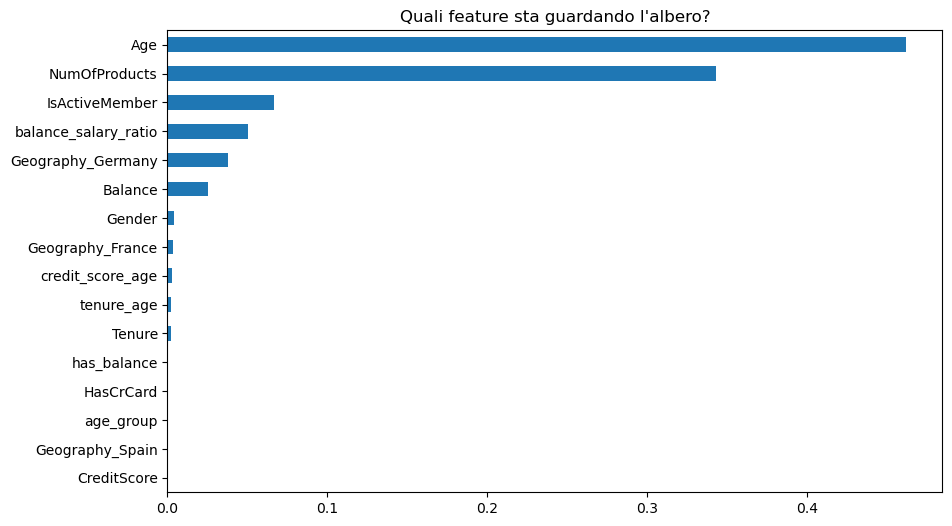

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

tree_classifier.fit(X_train, y_train)
importances = pd.Series(tree_classifier.feature_importances_, index=X_train.columns)

plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh')
plt.title("Quali feature sta guardando l'albero?")
plt.show()

Rimuovo tutto il rumore, considerando solo le top k (6) feature prese in considerazione dall'albero. Mi aspetto che l'accuracy e la precision aumentino.

In [72]:
features_to_use = [
    'Age',   
    'NumOfProducts',
    'IsActiveMember',   
    'balance_salary_ratio',
    'Geography_Germany',
    'Balance',           
]

X = df7[features_to_use]
y = df7['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=0)

tree_classifier = DecisionTreeClassifier(random_state = 0, max_depth=5, class_weight='balanced')
tree_classifier.fit(X=X_train, y=y_train)

y_predicted = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, f1: {f1:.3f}')

Accuracy: 0.749, Precision: 0.436, Recall: 0.794, f1: 0.563


Passiamo ad un Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=0, class_weight='balanced')

features_to_use = [
    'Age',   
    'NumOfProducts',
    'IsActiveMember',   
    'balance_salary_ratio',
    'Geography_Germany',
    'Balance',           
]

X = df7[features_to_use]
y = df7['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=0)

rf_classifier.fit(X_train, y_train)

y_predicted = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, f1: {f1:.3f}')

Accuracy: 0.843, Precision: 0.626, Recall: 0.566, f1: 0.594
